In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import skimage as ski
from scipy.signal import convolve2d, convolve

from skimage import draw

import random


(300, 400)

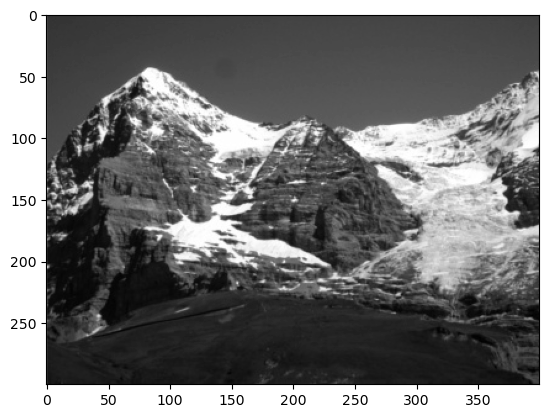

In [2]:
filename = "Docs - Primitives-20230926\pics\M1.JPG"
img = ski.io.imread(filename)
img_gray = ski.color.rgb2gray(img)

plt.imshow(img_gray, cmap='gray')
img_gray.shape

In [3]:
def harris_detector(img: np.ndarray, WS: int = 3, threshold: float = 0.01, k:float = 0.04, gauss: bool = False) :

    Ix, Iy= np.gradient(img)
    # plt.show(X_grad)

    if gauss == 1 :
        # Apply Gaussian blurring with
        Ix = ski.filters.gaussian(Ix, sigma=1)
        Iy = ski.filters.gaussian(Iy, sigma=1)

    offset = WS // 2
    height, width = img.shape
    corner_response = np.zeros((height, width))

    for y in range(offset, height - offset):
        for x in range(offset, width - offset):
            # Compute the structure tensor M for the current pixel
            M = np.zeros((2, 2))
            for i in range(-offset, offset + 1):
                for j in range(-offset, offset + 1):
                    Ix_val = Ix[y + i, x + j]
                    Iy_val = Iy[y + i, x + j]
                    M[0, 0] += Ix_val ** 2
                    M[0, 1] += Ix_val * Iy_val
                    M[1, 0] += Ix_val * Iy_val
                    M[1, 1] += Iy_val ** 2

            # Compute the corner response using the Harris formula
            det_M = np.linalg.det(M)
            trace_M = np.trace(M)
            corner_response[y, x] = det_M - k * (trace_M ** 2)

    # Threshold the corner response to identify significant corners
    corners = np.zeros_like(img)
    corners[corner_response > threshold * corner_response.max()] = [1]  # Mark corners in red

    corner_response[0,0] = 0
    corners[0,0] = [0]
    return corners, corner_response   


In [4]:
def harris_detector(img: np.ndarray, WS: int = 3, threshold: float = 0.01, k:float = 0.04, gauss: bool = False) :

    Ix, Iy= np.gradient(img)
    # plt.show(X_grad)

    height, width = img.shape
    corner_response = np.zeros((height, width))

    Ixx = Ix**2
    Iyy = Iy**2
    Ixy = Ix*Iy

    if gauss == 1 :
        # Apply Gaussian blurring with
        Ixx = ski.filters.gaussian(Ixx, sigma=(WS-1)/6)
        Iyy = ski.filters.gaussian(Iyy, sigma=(WS-1)/6)
        Ixy = ski.filters.gaussian(Ixy, sigma=(WS-1)/6)


    m = np.ones([WS,WS])

    cIxx = convolve2d(Ixx,m,'same')
    cIyy = convolve2d(Iyy,m,'same')
    cIxy = convolve2d(Ixy,m,'same')

    corner_response = (cIxx * cIyy - cIxy * cIxy) - k * (cIxx + cIyy)

    # Threshold the corner response to identify significant corners
    corners = np.zeros_like(img)
    corners[corner_response > threshold * corner_response.max()] = [1]  # Mark corners in red

    corner_response[0,0] = 0
    corners[0,0] = 0
    
    return corners, corner_response   


In [5]:
# Detect corners using the Harris Corner Detector whith rectangular window 
corner_image_1, corner_response_1 = harris_detector(img_gray, k=0.04,gauss = False)

# Detect corners using the Harris Corner Detector with gausian window
corner_image_2, corner_response_2 = harris_detector(img_gray, k=0.04,gauss = True)

# plt.figure(figsize=(15, 10))

# # rectangular window
# plt.subplot(1,2,1)
# plt.imshow(corner_image_1, cmap='gray')
# plt.title("rectangular window")

# # gausian window
# plt.subplot(1,2,2)
# plt.imshow(corner_image_2, cmap='gray')
# plt.title("gausian window")

# plt.show()

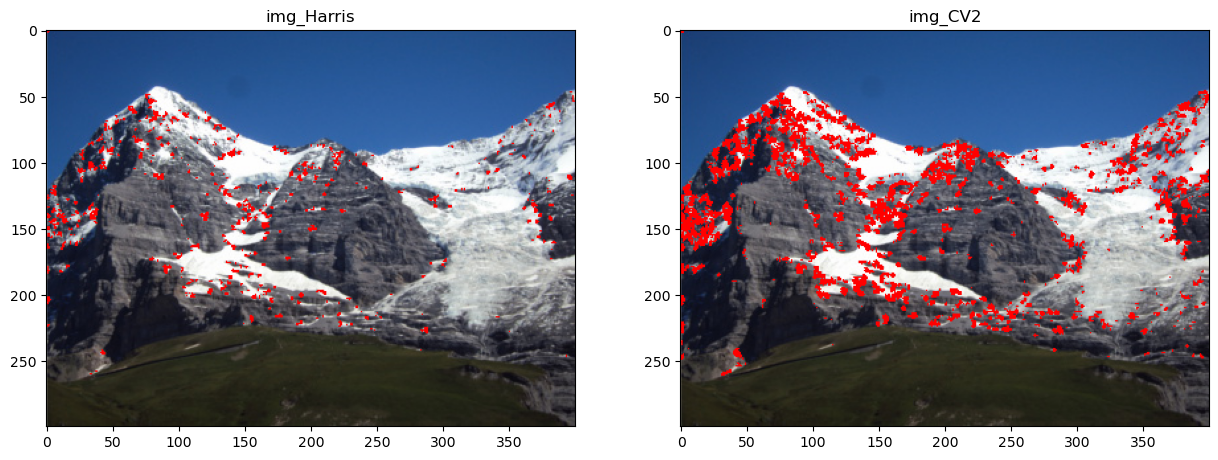

In [6]:
cv2_img = cv2.imread(filename)

# Convert the image to grayscale
cv2_img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Perform Harris Corner Detection
dst = cv2.cornerHarris(cv2_img_gray, blockSize=3, ksize=3, k=0.04)

# Threshold the corner response to identify significant corners
threshold = 0.01 * dst.max()
corner_image_dts = np.zeros(img_gray.shape)
corner_image_dts[dst > threshold] = [1]  # Mark corners in red

# Display the corners on the original image
plt.figure(figsize=(15, 10))

# Harris
plt.subplot(1,2,1)
img_Harris = img.copy()
img_Harris[corner_response_1 > 0.01 * corner_response_1.max()] = [255,0,0]
plt.imshow(img_Harris)
plt.title("img_Harris")

# CV2
plt.subplot(1,2,2)
img_CV2 = img.copy()
img_CV2[dst > 0.01 * dst.max()] = [255,0,0]
plt.imshow(img_CV2)
plt.title("img_CV2")

plt.show()

In [7]:
def RLM(corner_response, WS=5):
    height, width = corner_response.shape

    offset = WS //2

    corner_out = np.zeros([height, width])

    for i in range(offset, height-offset) :
        for j in range(offset, width-offset) : 

            if corner_response[i,j] < corner_response[i-offset:i+offset+1,j-offset:j+offset+1].max() or corner_response[i,j] < corner_response.max()*0.01 :
                corner_out[i,j] = 0
            else:
                corner_out[i,j] = 1


    return corner_out

Text(0.5, 1.0, 'img_Harris')

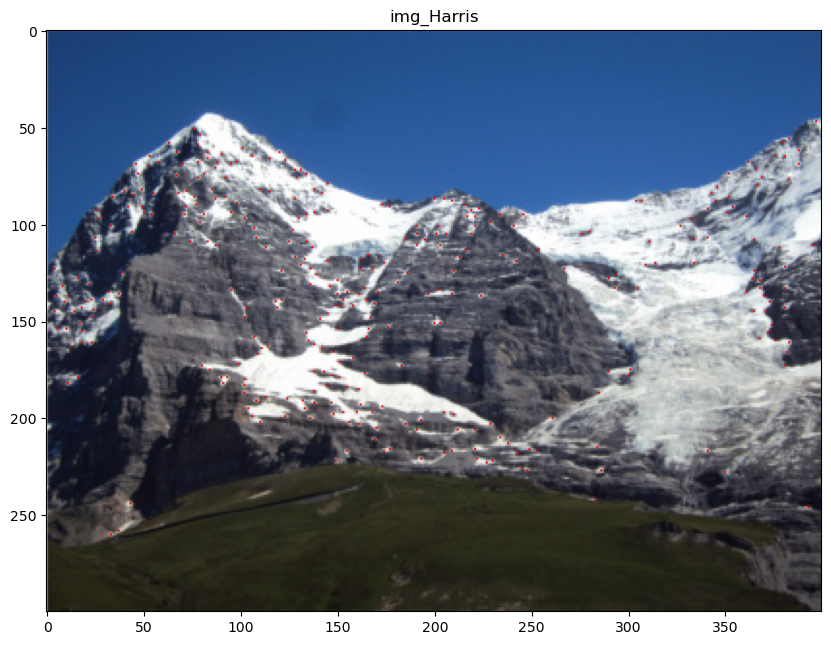

In [8]:
corner_response_rlm = RLM(corner_response_1)
plt.figure(figsize=(10, 10))
img_Harris = img.copy()
img_Harris[corner_response_rlm > 0.01 * corner_response_rlm.max()] = [255,0,0]
plt.imshow(img_Harris)
plt.title("img_Harris")


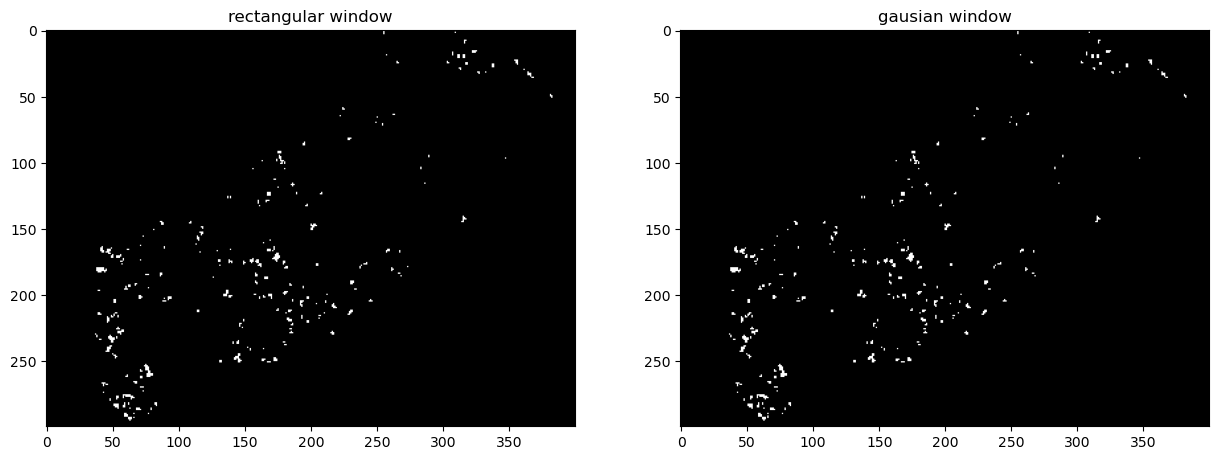

In [9]:
rot_img = ski.transform.rotate(img_gray, 45)

# Detect corners using the Harris Corner Detector whith rectangular window 
corner_image_1R, corner_response_1R = harris_detector(rot_img, k=0.04,gauss = False)

# Detect corners using the Harris Corner Detector with gausian window
corner_image_2R, corner_response_2R = harris_detector(rot_img, k=0.04,gauss = True)

plt.figure(figsize=(15, 10))

# rectangular window
plt.subplot(1,2,1)
plt.imshow(corner_image_1R, cmap='gray')
plt.title("rectangular window")

# gausian window
plt.subplot(1,2,2)
plt.imshow(corner_image_2R, cmap='gray')
plt.title("gausian window")

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


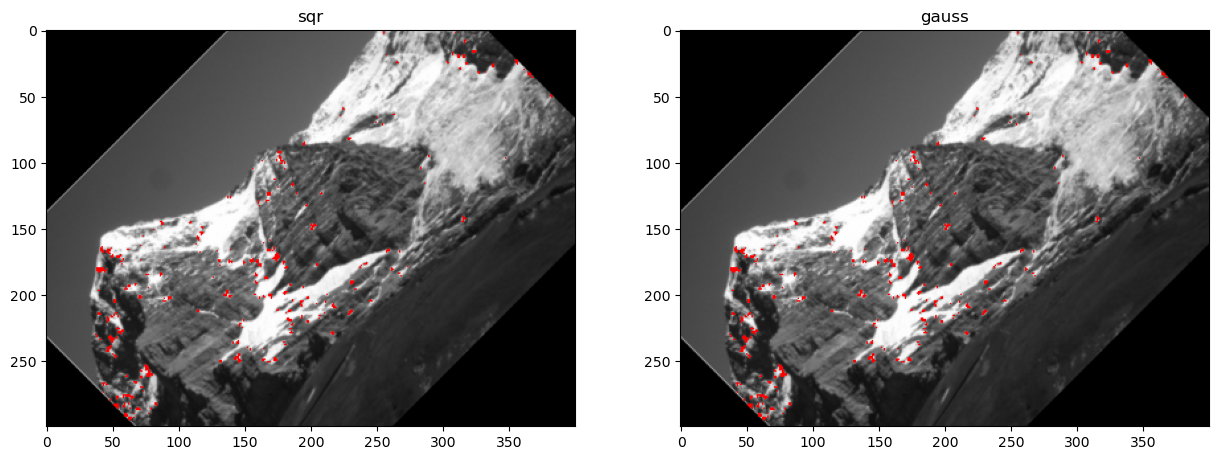

In [10]:
img1 = ski.color.gray2rgb(rot_img)
img2 = ski.color.gray2rgb(rot_img)

# Display the corners on the original image
plt.figure(figsize=(15, 10))

# Harris
plt.subplot(1,2,1)
img1[corner_image_1R == 1] = [255,0,0]  # Red channel
plt.imshow(img1)
plt.title("sqr")

# CV2
plt.subplot(1,2,2)
img2[corner_image_2R == 1] = [255,0,0]  # Red channel
plt.imshow(img2)
plt.title("gauss")

plt.show()

# FAST


In [11]:
def fast_corner_detector(img: np.ndarray, threshold=0.1):
    
    height, width = img.shape
    offset = 3

    corners = np.zeros([height, width])
    
    for x in range(offset, height - offset) : 
        for y in range(offset, width - offset) :
            pixel_intensity = img[x, y]
            
            # Coordinates of the 16 pixels in the Bresenham circle
            offsets = [         (-1, 3),(0, 3),(1, 3),
                        (-2, 2),                      (2, 2), 
                (-3, 1),                                    (3, 1), 
                (-3, 0),                                    (3, 0), 
                (-3,-1),                                    (3,-1), 
                        (-2,-2),                      (2,-2), 
                                (-1,-3),(0,-3),(1,-3)]
            
            
            V = np.zeros([16])
            
            k = 0
            Is = 0
            for i, j in offsets:

                if (pixel_intensity - threshold > img[x+i, y+j]):
                    V[k] = 1
                elif (pixel_intensity + threshold < img[x+i, y+j]):
                    V[k] = -1
                
                Is = abs(pixel_intensity + img[x+i, y+j])
                k+=1

            kernel = np.ones(12)
            padding = len(kernel) // 2

            padded_signal = np.concatenate([V[-padding:], V, V[:padding]])
            result = np.convolve(padded_signal, kernel, mode='valid')

            r = abs(result[padding:-padding]).max()

            if r >= 12 :
                corners[x, y] = Is/16

    return corners

Text(0.5, 1.0, 'img_Fast')

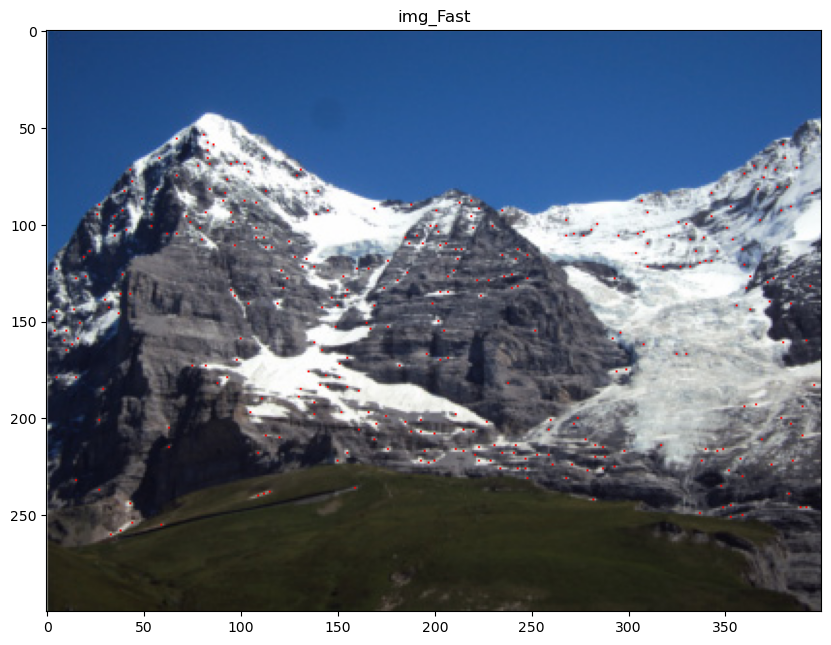

In [12]:
corner_response_1 = fast_corner_detector(img_gray, threshold=0.15)
corner_response_rlm_2 = RLM(corner_response_1)
plt.figure(figsize=(10, 10))
img_Fast = img.copy()
img_Fast[corner_response_rlm_2 == 1] = [255,0,0]
plt.imshow(img_Fast)
plt.title("img_Fast")

# EX2

In [166]:
def vect_int(img_gray, corner_response, blocSize=5):
    corner_response_rlm = RLM(corner_response)

    indices = np.argwhere(corner_response_rlm==1)

    # print(indices)
    V = np.zeros([len(indices),blocSize**2])

    h,w = img_gray.shape
    

    #print(w,h)

    indices_out = indices.copy()

    off = blocSize // 2
    i = 0
    for x,y in indices :

        # print(x,y)

        if x < off or y < off or x > h - off or x > w - off :

            print(x,y)
            indices_out = np.delete(indices_out, i, axis=0)
            i += 1

        else:

            I = img_gray[x-off:x+off+1,y-off:y+off+1]

            V[i,:] = I.flatten()
            i += 1
            
        
    return V,indices_out


In [178]:
filename1 = "Docs - Primitives-20230926\pics\M1.JPG"
filename2 = "Docs - Primitives-20230926\pics\M2.JPG"

img1_gray = ski.color.rgb2gray(ski.io.imread(filename1))
img2_gray = ski.color.rgb2gray(ski.io.imread(filename2))

# corner_response_1 = fast_corner_detector(img1_gray, threshold=0.15)
# corner_response_2 = fast_corner_detector(img2_gray, threshold=0.15)

_, corner_response_1 = harris_detector(img1_gray, k=0.04,gauss = True)
_, corner_response_2 = harris_detector(img2_gray, k=0.04,gauss = True)

corner_response_rlm_1 = RLM(corner_response_1)
corner_response_rlm_2 = RLM(corner_response_2)

V1,cor1 = vect_int(img1_gray, corner_response_rlm_1)
V2,cor2 = vect_int(img2_gray, corner_response_rlm_2)

print(V1.shape, V2.shape)

(335, 25) (376, 25)


In [179]:
def match(V1,V2) :
    # x,y = len(V1), len(V2)

    # D = np.zeros([x,y])

    # for i in range(x):
    #     v1 = V1[i,:]

    #     for j in range(y):
    #         v2 = V2[j,:]

    #         D[i,j] = np.abs(v1 - v2).sum()

    V1 = V1[:, np.newaxis,:]

    V = abs(V1 - V2)

    V = V.sum(axis=2)

    return V

In [180]:

def get_maxs(V1, V2, n):

    D = match(V1,V2)
    X = []
    Y = []
    for _ in range(n) :

        x,y = np.unravel_index(np.argmin(D, axis=None), D.shape)

        X.append(x)
        Y.append(y)

        D[x,:] = D.max()
        D[:,y] = D.max()

    return X, Y


In [181]:
pv1,pv2 = get_maxs(V1, V2, 10)

P1 = cor1[pv1]
P2 = cor2[pv2]


105 276
101 327
92 341
120 314
221 222
203 185
210 234
136 197
135 361
62 388


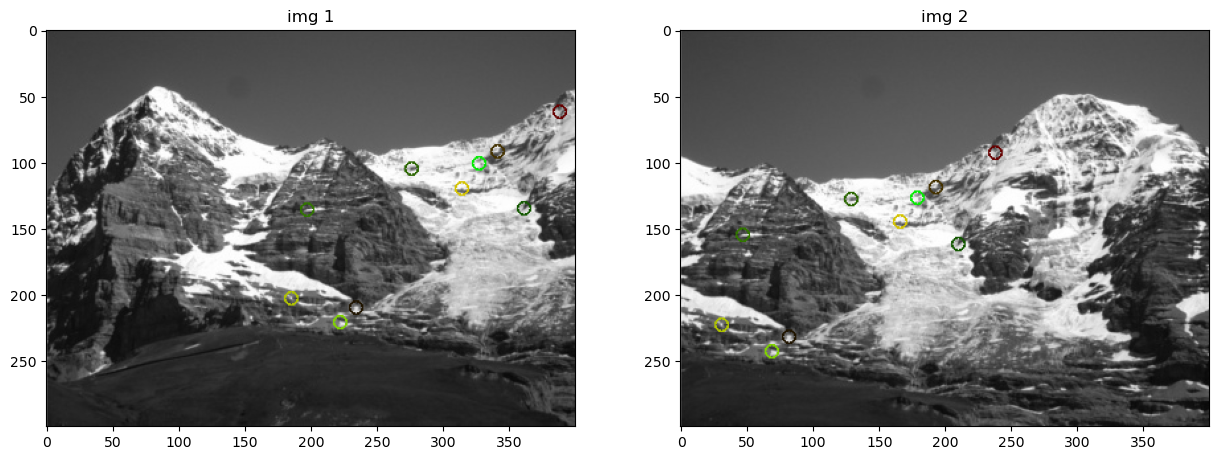

In [182]:
img1 = ski.color.gray2rgb(img1_gray)
img2 = ski.color.gray2rgb(img2_gray)


for i in range(len(P1)) :

    r = random.random()
    g = random.random()
    b = 0
    
    print(P1[i,0],P1[i,1])
    
    rr1, cc1, _ = draw.circle_perimeter_aa(P1[i,0],P1[i,1], radius=5, shape=img1.shape)
    img1[rr1, cc1] = (r,g,0)

    rr2, cc2, _ = draw.circle_perimeter_aa(P2[i,0],P2[i,1], radius=5, shape=img2.shape)
    img2[rr2, cc2] = [r,g,0]



# Display the corners on the original image
plt.figure(figsize=(15, 10))

plt.subplot(1,2,1)
plt.imshow(img1)
plt.title("img 1")

# CV2
plt.subplot(1,2,2)
plt.imshow(img2)
plt.title("img 2")

plt.show()

In [147]:
a = np.array([[1,2,3],
              [2,2,2],
              [1,1,1],
              [1,5,1]])

b = np.array([[1,2,3],
              [4,5,2],
              [1,8,1]])

a = a[:, np.newaxis,:]

c = abs(b - a)

c = c.sum(axis=2)

c[1,0]

2